In [1]:
#-*- coding:utf8-*-
%matplotlib inline

from __future__ import absolute_import, division, print_function, unicode_literals

from IPython.display import Image

import numpy as np

import uncertainties as unc
from uncertainties import unumpy as unp
from uncertainties.unumpy import std_devs as stds #TODO
from uncertainties.unumpy import nominal_values as noms #TODO

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D 

import seaborn as sns
sns.set(context="paper",font_scale=1.4)
colors = sns.color_palette()
#sns.set_context(rc={'lines.markeredgewidth': 0.5})

import scipy as sp
import scipy.constants as const

import sympy as sym

import pandas as pd

#import ROOT as rt

#import root_numpy as rnp

from aputils.latextables.tables import Table


# Fehlerfortpflanzung beim Mitteln
umean = unc.wrap(np.mean)

#Laden des Latex fonts 
plt.rcParams['text.latex.preamble']=["\\usepackage{lmodern}"]
#Options
params = {'text.usetex' : True,
          'font.size' : 11,
          'font.family' : 'lmodern',
          'text.latex.unicode': True,
          }
plt.rcParams.update(params) 

#Größe der Achsenbeschriftung
axis_font = {'size':'14'}

# Pfade
path_graphics = "../Grafiken/"
path_table = "../Tabellen/"
path_data = "../Messdaten/"
path_results = "../Ergebnisse/"

In [2]:
# Funktionen
# Achsenbeschriftungen
def axis_label(label,sym=None,unit=None):
    if sym == None:
        return lable
    elif unit == None:
        return r"".join([label," ${s}$".format(s=sym)])
    else:
        return r"".join([label," ${s}/\mathrm{{{u}}}$".format(s=sym,u=unit)])

# Achsenskalierung
def axis_scale(factor, axis="x"):
    if axis == "x":
        plt.gca().xaxis.set_major_formatter(mpl.ticker.FuncFormatter(lambda x, _: x * factor))
    elif axis == "y":
        plt.gca().yaxis.set_major_formatter(mpl.ticker.FuncFormatter(lambda x, _: x * factor))
    else:
        print("Wrong axis name given! Only x and y are allowed!")

def siunitx_ticklabels(ax=None, locale="DE", xaxis=True, yaxis=True,
                       round_precision=2, round_mode="places", scale_x=None, scale_y=None):
    """
    This function uses siunitx to create the ticklabels
    Main reason is for adjusting the decimal marker properly.
    The function takes 4 arguments:
        ax=None     the matplotlib axes to operate on
                    if set to None (Standard) this will be the current axes
        locale="DE" The locale parameter for siunitx, one of
                    "UK", "US", "DE", "FR" oder "ZA"
        xaxis=True  Boolean, if True the labels for the xaxis are set
        yaxis=True  Boolean, if True the labels for the yaxis are set
        round_precision=2 Number of places or figures after rounding
        round_mode="places" Rounds to round_precision many decimal places,
                  "figures" Rounds to round_precision many significant figures
                  
    """

    if ax is None:
        ax = plt.gca()

    if scale_x == None:
        scale_x = 1
    if scale_y == None:
        scale_y = 1
        
        
    if xaxis is True:
        xticks = ax.get_xticks()
        print(xticks)
        xlabels = [r"$\num[locale={},round-mode={},round-precision={}]{{{}}}$".format(
                   locale, round_mode,round_precision, tick*scale_x) for tick in xticks]
        #print(xlabels)
        ax.set_xticklabels(xlabels)

    if yaxis is True:
        yticks = ax.get_yticks()
        ylabels = [r"$\num[locale={},round-mode={},round-precision={}]{{{}}}$".format(
                   locale, round_mode,round_precision, tick*scale_y) for tick in yticks]
        #print(ylabels)
        ax.set_yticklabels(ylabels)    

        
def errorbar(x,y,marker="o",linestyle="",color=None, ax=None,label="", factor=1):
    if ax is None:
        ax = plt.gca()
    ax.errorbar(noms(x),noms(y), xerr=stds(x)*factor, yerr=stds(y)*factor,color=color, marker=marker, linestyle=linestyle,label=label)
    

# Fit Funktionen
def fit_errors(popt,pcov):
    errors = np.sqrt(np.diag(pcov))
    param_err = unp.uarray(popt,errors)
    return param_err
    
def print_errors(array,description=None):
    if description and len(description)==len(array):
        maxlen = max(map(len,description))
        lens = list(map(len,description))
        for i,entry in enumerate(array):
            print(description[i]," "*(maxlen-lens[i]),entry.nominal_value,"+/-",entry.std_dev)
    else:
        for i,entry in enumerate(array):
            print(entry.nominal_value,"+/-",entry.std_dev)

def save_results(value,unit,file):
    significant_figure = abs(int(np.log10(stds(value))))
    std = int(np.round(stds(value),significant_figure)*10**significant_figure)
    
    siuntix_string = "\\SI{{{v}({s})}}{{{u}}}".format(v=np.round(noms(value),significant_figure),s=std,u=unit)
    with open(path_results+file,"w") as f:
        print(siuntix_string, file=f)

In [3]:
linear_func = lambda x,a,b: x**a * 10**b #lambda x,a,b: a * x + b

## Laden der Messdaten gegengekoppelter Verstärker a)

In [4]:
degenerative_amplifier_err = pd.read_csv(path_data + "Fehler_Gegengekoppelter_Verstaerker.csv",
                                       skiprows=1, names=("f","U1","UA","R","Phase") )

In [5]:
degenerative_amplifier_err

,f,U1,UA,R,Phase
0,0.01,1,5,0.01,5


In [6]:
degenerative_amplifier_resistors = pd.read_csv(path_data + "Widerstaende_Gegengekoppelter_Verstaerker.csv",
                                       skiprows=1, names=("RN","R1") )

In [7]:
degenerative_amplifier_resistors

,RN,R1
0,100,100
1,10,100
2,10,32
3,32,10


In [8]:
degenerative_amplifier_resistors["RN"] = unp.uarray(degenerative_amplifier_resistors["RN"],
                                                    degenerative_amplifier_resistors["RN"]*degenerative_amplifier_err["R"][0])
degenerative_amplifier_resistors["R1"] = unp.uarray(degenerative_amplifier_resistors["R1"],
                                                    degenerative_amplifier_resistors["R1"]*degenerative_amplifier_err["R"][0])

In [9]:
degenerative_amplifier_resistors

,RN,R1
0,100.0+/-1.0,100.0+/-1.0
1,10.00+/-0.10,100.0+/-1.0
2,10.00+/-0.10,32.00+/-0.32
3,32.00+/-0.32,10.00+/-0.10


In [10]:
degenerative_amplifier_resistors["RN/R1"] = (degenerative_amplifier_resistors["RN"]/degenerative_amplifier_resistors["R1"]).values
degenerative_amplifier_resistors

,RN,R1,RN/R1
0,100.0+/-1.0,100.0+/-1.0,1.000+/-0.014
1,10.00+/-0.10,100.0+/-1.0,0.1000+/-0.0014
2,10.00+/-0.10,32.00+/-0.32,0.312+/-0.004
3,32.00+/-0.32,10.00+/-0.10,3.20+/-0.05


In [11]:
degenerative_amplifier_resistors["logRN/R1"] = unp.log10(degenerative_amplifier_resistors["RN/R1"].values)
degenerative_amplifier_resistors

,RN,R1,RN/R1,logRN/R1
0,100.0+/-1.0,100.0+/-1.0,1.000+/-0.014,0.000+/-0.006
1,10.00+/-0.10,100.0+/-1.0,0.1000+/-0.0014,-1.000+/-0.006
2,10.00+/-0.10,32.00+/-0.32,0.312+/-0.004,-0.505+/-0.006
3,32.00+/-0.32,10.00+/-0.10,3.20+/-0.05,0.505+/-0.006


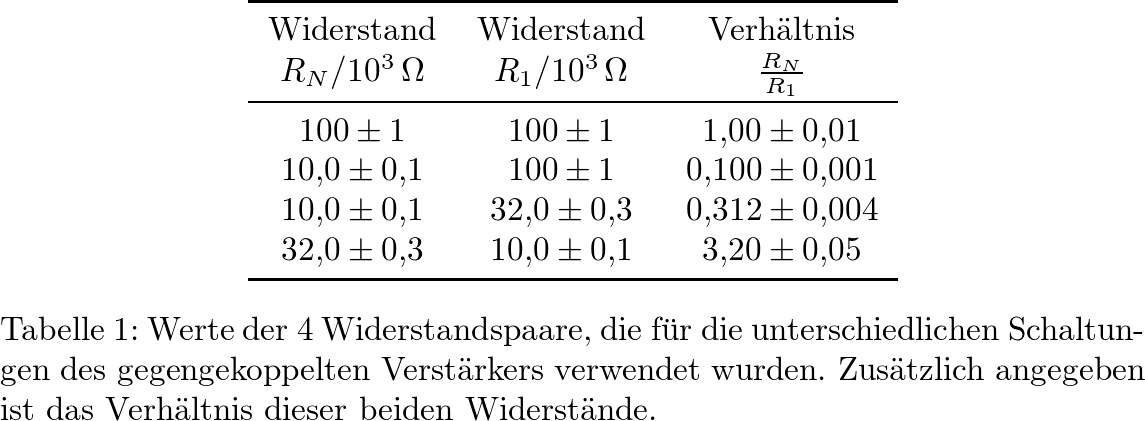

In [12]:
Tab = Table(siunitx=True,booktabs=True)
Tab.caption("""Werte der 4 Widerstandspaare, die für die unterschiedlichen Schaltungen des gegengekoppelten Verstärkers 
verwendet wurden. Zusätzlich angegeben ist das Verhältnis dieser beiden Widerstände.""")
Tab.label("gegegengekoppelt_widerstaende")
Tab.addColumn(degenerative_amplifier_resistors["RN"],title="Widerstand",symbol="R_N",unit="\\kilo\\ohm")
Tab.addColumn(degenerative_amplifier_resistors["R1"],title="Widerstand",symbol="R_1",unit="\\kilo\\ohm")
Tab.addColumn(degenerative_amplifier_resistors["RN/R1"],title="Verhältnis",symbol="\\frac{R_N}{R_1}")
#Tab.addColumn(degenerative_amplifier_resistors["logRN/R1"],title="log. Verhältnis",symbol="\log \\frac{R_N}{R_1}")
Image(Tab.show(ipynb=True,quiet=False),width=800)

In [13]:
#Tab.save(path_table+"Gegengekoppelter_Verstaerker_Widerstaende.tex")

## Messreihe 1

In [14]:
degenerative_amplifier_1 = pd.read_csv(path_data + "Frequenzgang_Gegengekoppelter_Verstaerker_1.csv",
                                       skiprows=1, names=("f","U1","UA"))

degenerative_amplifier_1["f"] = unp.uarray(degenerative_amplifier_1["f"],
                                           degenerative_amplifier_1["f"]*degenerative_amplifier_err["f"][0])
degenerative_amplifier_1["U1"] = unp.uarray(degenerative_amplifier_1["U1"],
                                           degenerative_amplifier_err["U1"][0])
degenerative_amplifier_1["UA"] = unp.uarray(degenerative_amplifier_1["UA"],
                                           degenerative_amplifier_err["UA"][0])

degenerative_amplifier_1["V"] = degenerative_amplifier_1["UA"]/degenerative_amplifier_1["U1"]
degenerative_amplifier_1["logf"] = unp.log10(degenerative_amplifier_1["f"])
degenerative_amplifier_1["logV"] = unp.log10(degenerative_amplifier_1["V"])

In [15]:
degenerative_amplifier_1

,f,U1,UA,V,logf,logV
0,1.000+/-0.010,70.0+/-1.0,78.0+/-5.0,1.11+/-0.07,0.000+/-0.004,0.047+/-0.029
1,5.00+/-0.05,70.0+/-1.0,72.0+/-5.0,1.03+/-0.07,0.699+/-0.004,0.012+/-0.031
2,10.00+/-0.10,70.0+/-1.0,57.0+/-5.0,0.81+/-0.07,1.000+/-0.004,-0.09+/-0.04
3,15.00+/-0.15,70.0+/-1.0,45.0+/-5.0,0.64+/-0.07,1.176+/-0.004,-0.19+/-0.05
4,20.00+/-0.20,70.0+/-1.0,37.0+/-5.0,0.53+/-0.07,1.301+/-0.004,-0.28+/-0.06
5,25.00+/-0.25,70.0+/-1.0,31.0+/-5.0,0.44+/-0.07,1.398+/-0.004,-0.35+/-0.07
6,30.00+/-0.30,70.0+/-1.0,25.0+/-5.0,0.36+/-0.07,1.477+/-0.004,-0.45+/-0.09
7,35.00+/-0.35,70.0+/-1.0,25.0+/-5.0,0.36+/-0.07,1.544+/-0.004,-0.45+/-0.09
8,75.0+/-0.8,70.0+/-1.0,20.0+/-5.0,0.29+/-0.07,1.875+/-0.004,-0.54+/-0.11
9,100.0+/-1.0,70.0+/-1.0,15.0+/-5.0,0.21+/-0.07,2.000+/-0.004,-0.67+/-0.14


In [16]:
popt, pcov = sp.optimize.curve_fit(linear_func, 
                                   noms(degenerative_amplifier_1["f"][2:]),
                                   noms(degenerative_amplifier_1["V"][2:]),
                                   sigma=stds(degenerative_amplifier_1["V"][2:]))
param_a, param_b = fit_errors(popt,pcov)

print_errors([param_a,param_b],description=("Steigung a","y-Achsenabschnitt b"))

x = np.linspace(min(noms(degenerative_amplifier_1["f"])), max(noms(degenerative_amplifier_1["f"])), 1000)
y = linear_func(x,noms(param_a), noms(param_b))

param_a_1,param_b_1 = param_a,param_b

Steigung a           -0.6133904970376055 +/- 0.043550652273479554
y-Achsenabschnitt b  0.5188387058375871 +/- 0.0554429180089371


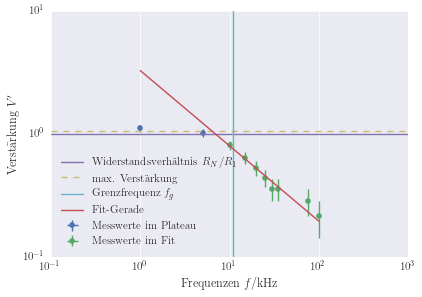

In [17]:
fig,ax = plt.subplots()
ax.set_xlabel(axis_label("Frequenzen", "f", "kHz"))
ax.set_ylabel(axis_label("Verstärkung", "V^{\prime}"))

ax.set_xscale("log")
ax.set_yscale("log")


plateau = np.mean(noms(degenerative_amplifier_1["V"][:2]))
plateau_sq2 = plateau/np.sqrt(2) 
#frequency_limit0 = sp.optimize.fsolve(lambda x:x**noms(param_a) * 10**noms(param_b) - plateau_sq2,x0=1)
frequency_limit = (plateau_sq2/10**param_b)**(1/param_a)

errorbar(degenerative_amplifier_1["f"][:2],degenerative_amplifier_1["V"][:2],
        marker="o", linestyle="", ax=ax, label="Messwerte im Plateau")
errorbar(degenerative_amplifier_1["f"][2:],degenerative_amplifier_1["V"][2:],
        marker="o", linestyle="", ax=ax, label="Messwerte im Fit")

ax.axhline(noms(degenerative_amplifier_resistors["RN"][0]/degenerative_amplifier_resistors["R1"][0]), 
           label="Widerstandsverhältnis $R_N/R_1$",color=colors[3])
ax.axhline(plateau, label="max. Verstärkung",linestyle="dashed",color=colors[4])
ax.axvline(frequency_limit.n,color=colors[5], label="Grenzfrequenz $f_g$")

ylim = ax.get_ylim()
ylim_mask = (y>ylim[0])&(y<ylim[1])

ax.plot(x[ylim_mask],y[ylim_mask],label="Fit-Gerade")
ax.legend(loc="lower left")
fig.savefig(path_graphics+"Gegengekoppelter_Verstaerker_1.pdf")


In [18]:
f_1 = frequency_limit
Vf_1 = frequency_limit * plateau
print("Grenzfrequenz", frequency_limit, "kHz")
print("Verstärkung-Bandbreite-Produkt",frequency_limit * plateau)
plateau_1 = plateau
resistor_ratio_1 = noms(degenerative_amplifier_resistors["RN"]/degenerative_amplifier_resistors["R1"])[0]
relative_difference_1 = abs(resistor_ratio_1- plateau_1)/resistor_ratio_1
print("Widerstandsverhältnis", resistor_ratio_1)
print("Plateau-Höhe", plateau_1)
print("relative Abweichung", relative_difference_1)
idel_amplification_1 = noms(degenerative_amplifier_resistors["RN"] * plateau /(degenerative_amplifier_resistors["RN"]
                                                              - (degenerative_amplifier_resistors["R1"] * plateau)))[0]
print("Leerlaufverstärkung", idel_amplification_1)

Grenzfrequenz 11.0+/-3.0 kHz
Verstärkung-Bandbreite-Produkt 11.8+/-3.2
Widerstandsverhältnis 1.0
Plateau-Höhe 1.07142857143
relative Abweichung 0.0714285714286
Leerlaufverstärkung -15.0


In [19]:
frequency_limit.error_components()

{-0.6133904970376055+/-0.043550652273479554: 1.878839829767922,
 0.5188387058375871+/-0.0554429180089371: 2.2946267455173177}

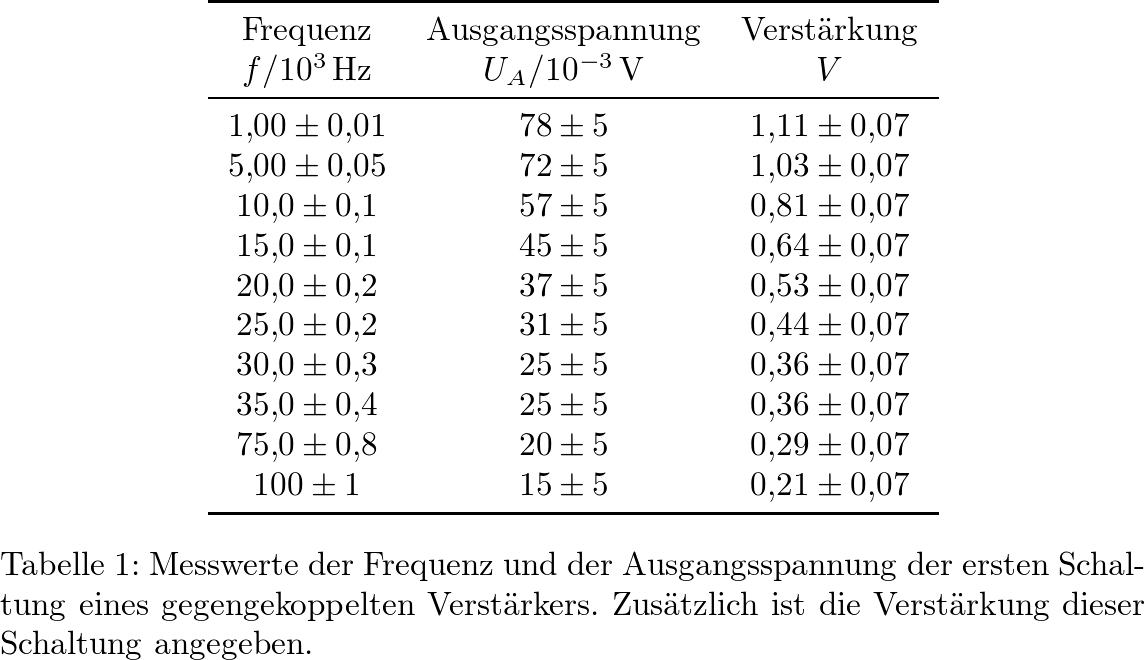

In [20]:
Tab = Table(siunitx=True,booktabs=True)
Tab.caption("""Messwerte der Frequenz und der Ausgangsspannung der ersten Schaltung eines gegengekoppelten Verstärkers.
            Zusätzlich ist die Verstärkung dieser Schaltung angegeben.""")
Tab.label("gegengekoppelter_verstaerker_1")
Tab.addColumn(degenerative_amplifier_1["f"],title="Frequenz",symbol="f",unit="\\kilo\\hertz")
Tab.addColumn(degenerative_amplifier_1["UA"],title="Ausgangsspannung",symbol="U_A",unit="\\milli\\volt")
Tab.addColumn(degenerative_amplifier_1["V"],title="Verstärkung",symbol="V")
Image(Tab.show(ipynb=True,quiet=False),width=800)

Tab.save(path_table+"Gegengekoppelter_Verstaerker_1.tex")

## Messreihe 2


In [21]:
degenerative_amplifier_2 = pd.read_csv(path_data + "Frequenzgang_Gegengekoppelter_Verstaerker_2.csv",
                                       skiprows=1, names=("f","U1","UA"))

degenerative_amplifier_2["f"] = unp.uarray(degenerative_amplifier_2["f"],
                                           degenerative_amplifier_2["f"]*degenerative_amplifier_err["f"][0])
degenerative_amplifier_2["U1"] = unp.uarray(degenerative_amplifier_2["U1"],
                                           degenerative_amplifier_err["U1"][0])
degenerative_amplifier_2["UA"] = unp.uarray(degenerative_amplifier_2["UA"],
                                           degenerative_amplifier_err["UA"][0])

degenerative_amplifier_2["V"] = degenerative_amplifier_2["UA"]/degenerative_amplifier_2["U1"]
degenerative_amplifier_2["logf"] = unp.log10(degenerative_amplifier_2["f"])
degenerative_amplifier_2["logV"] = unp.log10(degenerative_amplifier_2["V"])

In [22]:
degenerative_amplifier_2

,f,U1,UA,V,logf,logV
0,0.1000+/-0.0010,70.0+/-1.0,25.0+/-5.0,0.36+/-0.07,-1.000+/-0.004,-0.45+/-0.09
1,1.000+/-0.010,70.0+/-1.0,22.0+/-5.0,0.31+/-0.07,0.000+/-0.004,-0.50+/-0.10
2,5.00+/-0.05,70.0+/-1.0,18.0+/-5.0,0.26+/-0.07,0.699+/-0.004,-0.59+/-0.12
3,10.00+/-0.10,70.0+/-1.0,18.0+/-5.0,0.26+/-0.07,1.000+/-0.004,-0.59+/-0.12
4,20.00+/-0.20,70.0+/-1.0,16.0+/-5.0,0.23+/-0.07,1.301+/-0.004,-0.64+/-0.14
5,50.0+/-0.5,70.0+/-1.0,11.0+/-5.0,0.16+/-0.07,1.699+/-0.004,-0.80+/-0.20


In [23]:
popt, pcov = sp.optimize.curve_fit(linear_func, 
                                   noms(degenerative_amplifier_2["f"][2:]),
                                   noms(degenerative_amplifier_2["V"][2:]),
                                   sigma=stds(degenerative_amplifier_2["V"][2:]))
param_a, param_b = fit_errors(popt,pcov)

print_errors([param_a,param_b],description=("Steigung a","y-Achsenabschnitt b"))


x = np.linspace(min(noms(degenerative_amplifier_2["f"])), max(noms(degenerative_amplifier_2["f"])), 1000)
y = linear_func(x,noms(param_a), noms(param_b))

param_a_2,param_b_2 = param_a,param_b

Steigung a           -0.18839407811618122 +/- 0.06920331300628896
y-Achsenabschnitt b  -0.4316772524679522 +/- 0.07733969674992675


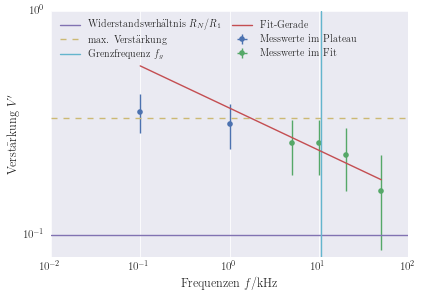

In [24]:
fig,ax = plt.subplots()
ax.set_xlabel(axis_label("Frequenzen", "f", "kHz"))
ax.set_ylabel(axis_label("Verstärkung", "V^{\prime}"))

ax.set_xscale("log")
ax.set_yscale("log")

ax.set_ylim(0.08,1.0)

plateau = np.mean(noms(degenerative_amplifier_2["V"][:2]))
plateau_sq2 = plateau/np.sqrt(2) 
frequency_limit = (plateau_sq2/10**param_b)**(1/param_a) #sp.optimize.fsolve(lambda x:x**noms(param_a) * 10**noms(param_b) - plateau_sq2,x0=1)

errorbar(degenerative_amplifier_2["f"][:2],degenerative_amplifier_2["V"][:2],
        marker="o", linestyle="", ax=ax, label="Messwerte im Plateau")
errorbar(degenerative_amplifier_2["f"][2:],degenerative_amplifier_2["V"][2:],
        marker="o", linestyle="", ax=ax, label="Messwerte im Fit")

ax.axhline(noms(degenerative_amplifier_resistors["RN"][1]/degenerative_amplifier_resistors["R1"][1]), 
           label="Widerstandsverhältnis $R_N/R_1$",color=colors[3])

ax.axhline(plateau, label="max. Verstärkung",linestyle="dashed",color=colors[4])
ax.axvline(frequency_limit.n,color=colors[5], label="Grenzfrequenz $f_g$")


ylim = ax.get_ylim()
ylim_mask = (y>ylim[0])&(y<ylim[1])

ax.plot(x[ylim_mask],y[ylim_mask],label="Fit-Gerade")
ax.legend(loc="upper left", ncol=2, columnspacing=1.2, fontsize=10)
fig.savefig(path_graphics+"Gegengekoppelter_Verstaerker_2.pdf")


In [25]:
f_2 = frequency_limit
Vf_2 = frequency_limit * plateau
print("Grenzfrequenz", frequency_limit, "kHz")
print("Verstärkung-Bandbreite-Produkt",frequency_limit * plateau)
plateau_2 = plateau
resistor_ratio_2 = noms(degenerative_amplifier_resistors["RN"]/degenerative_amplifier_resistors["R1"])[1]
relative_difference_2 = abs(resistor_ratio_2- plateau_2)/resistor_ratio_2
print("Widerstandsverhältnis", resistor_ratio_2)
print("Plateau-Höhe", plateau_2)
print("relative Abweichung", relative_difference_2)
idel_amplification_2 = noms(degenerative_amplifier_resistors["RN"] * plateau /(degenerative_amplifier_resistors["RN"]
                                                              - (degenerative_amplifier_resistors["R1"] * plateau)))[1]
print("Leerlaufverstärkung", idel_amplification_2)

Grenzfrequenz 10.6+/-13.5 kHz
Verstärkung-Bandbreite-Produkt 3.5+/-4.5
Widerstandsverhältnis 0.1
Plateau-Höhe 0.335714285714
relative Abweichung 2.35714285714
Leerlaufverstärkung -0.142424242424


In [26]:
f_ec = frequency_limit.error_components()
f_ecv = list(f_ec.values())
f_ec

{-0.4316772524679522+/-0.07733969674992675: 9.983852956183503,
 -0.18839407811618122+/-0.06920331300628896: 9.145666357405588}

In [27]:
np.sqrt(f_ecv[0]**2 + f_ecv[1]**2)

13.539591314795084

In [28]:
frequency_limit

10.56202691212786+/-13.539591314795084

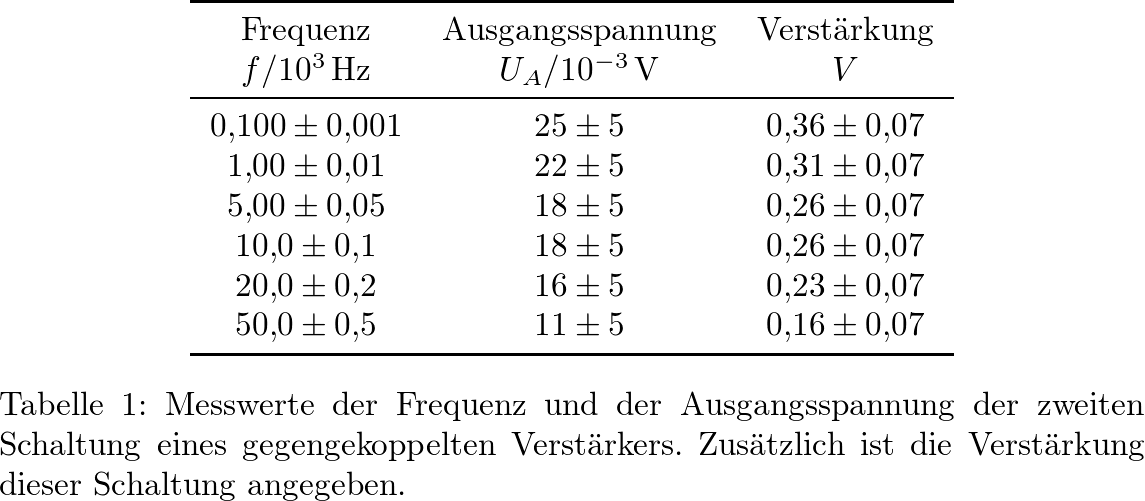

In [29]:
Tab = Table(siunitx=True,booktabs=True)
Tab.caption("""Messwerte der Frequenz und der Ausgangsspannung der zweiten Schaltung eines gegengekoppelten Verstärkers.
            Zusätzlich ist die Verstärkung dieser Schaltung angegeben.""")
Tab.label("gegengekoppelter_verstaerker_2")
Tab.addColumn(degenerative_amplifier_2["f"],title="Frequenz",symbol="f",unit="\\kilo\\hertz")
Tab.addColumn(degenerative_amplifier_2["UA"],title="Ausgangsspannung",symbol="U_A",unit="\\milli\\volt")
Tab.addColumn(degenerative_amplifier_2["V"],title="Verstärkung",symbol="V")
Image(Tab.show(ipynb=True,quiet=False),width=800)

Tab.save(path_table+"Gegengekoppelter_Verstaerker_2.tex")

## Messreihe 3

In [30]:
degenerative_amplifier_3 = pd.read_csv(path_data + "Frequenzgang_Gegengekoppelter_Verstaerker_3.csv",
                                       skiprows=1, names=("f","U1","UA"))

degenerative_amplifier_3["f"] = unp.uarray(degenerative_amplifier_3["f"],
                                           degenerative_amplifier_3["f"]*degenerative_amplifier_err["f"][0])
degenerative_amplifier_3["U1"] = unp.uarray(degenerative_amplifier_3["U1"],
                                           degenerative_amplifier_err["U1"][0])
degenerative_amplifier_3["UA"] = unp.uarray(degenerative_amplifier_3["UA"],
                                           degenerative_amplifier_err["UA"][0])

degenerative_amplifier_3["V"] = degenerative_amplifier_3["UA"]/degenerative_amplifier_3["U1"]
degenerative_amplifier_3["logf"] = unp.log10(degenerative_amplifier_3["f"])
degenerative_amplifier_3["logV"] = unp.log10(degenerative_amplifier_3["V"])

In [31]:
degenerative_amplifier_3

,f,U1,UA,V,logf,logV
0,0.01000+/-0.00010,70.0+/-1.0,37.0+/-5.0,0.53+/-0.07,-2.000+/-0.004,-0.28+/-0.06
1,0.1000+/-0.0010,70.0+/-1.0,35.0+/-5.0,0.50+/-0.07,-1.000+/-0.004,-0.30+/-0.06
2,1.000+/-0.010,70.0+/-1.0,38.0+/-5.0,0.54+/-0.07,0.000+/-0.004,-0.27+/-0.06
3,10.00+/-0.10,70.0+/-1.0,32.0+/-5.0,0.46+/-0.07,1.000+/-0.004,-0.34+/-0.07
4,20.00+/-0.20,70.0+/-1.0,30.0+/-5.0,0.43+/-0.07,1.301+/-0.004,-0.37+/-0.07
5,30.00+/-0.30,70.0+/-1.0,25.0+/-5.0,0.36+/-0.07,1.477+/-0.004,-0.45+/-0.09
6,40.0+/-0.4,70.0+/-1.0,19.0+/-5.0,0.27+/-0.07,1.602+/-0.004,-0.57+/-0.11
7,50.0+/-0.5,70.0+/-1.0,19.0+/-5.0,0.27+/-0.07,1.699+/-0.004,-0.57+/-0.11
8,100.0+/-1.0,70.0+/-1.0,16.0+/-5.0,0.23+/-0.07,2.000+/-0.004,-0.64+/-0.14


In [32]:
popt, pcov = sp.optimize.curve_fit(linear_func, 
                                   noms(degenerative_amplifier_3["f"][3:]),
                                   noms(degenerative_amplifier_3["V"][3:]),
                                   sigma=stds(degenerative_amplifier_3["V"][3:]))
param_a, param_b = fit_errors(popt,pcov)

print_errors([param_a,param_b],description=("Steigung a","y-Achsenabschnitt b"))

x = np.linspace(min(noms(degenerative_amplifier_3["f"])), max(noms(degenerative_amplifier_3["f"])), 1000)
y = linear_func(x,noms(param_a), noms(param_b))

param_a_3,param_b_3 = param_a,param_b

Steigung a           -0.32409599685032225 +/- 0.055292065346214433
y-Achsenabschnitt b  0.0047634669809800715 +/- 0.07751276264228699


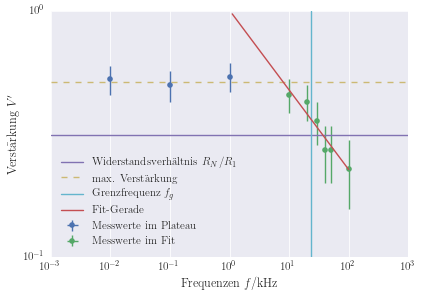

In [33]:
fig,ax = plt.subplots()
ax.set_xlabel(axis_label("Frequenzen", "f", "kHz"))
ax.set_ylabel(axis_label("Verstärkung", "V^{\prime}"))

ax.set_xscale("log")
ax.set_yscale("log")

plateau = np.mean(noms(degenerative_amplifier_3["V"][:2]))
plateau_sq2 = plateau/np.sqrt(2) 
frequency_limit = (plateau_sq2/10**param_b)**(1/param_a) # sp.optimize.fsolve(lambda x:x**noms(param_a) * 10**noms(param_b) - plateau_sq2,x0=1)


errorbar(degenerative_amplifier_3["f"][:3],degenerative_amplifier_3["V"][:3],
        marker="o", linestyle="", ax=ax, label="Messwerte im Plateau ")
errorbar(degenerative_amplifier_3["f"][3:],degenerative_amplifier_3["V"][3:],
        marker="o", linestyle="", ax=ax, label="Messwerte im Fit")

ax.axhline(noms(degenerative_amplifier_resistors["RN"][2]/degenerative_amplifier_resistors["R1"][2]), 
           label="Widerstandsverhältnis $R_N/R_1$",color=colors[3])

ax.axhline(plateau, label="max. Verstärkung",linestyle="dashed",color=colors[4])
ax.axvline(frequency_limit.n,color=colors[5], label="Grenzfrequenz $f_g$")


ylim = ax.get_ylim()
ylim_mask = (y>ylim[0])&(y<ylim[1])

ax.plot(x[ylim_mask],y[ylim_mask],label="Fit-Gerade")
ax.legend(loc="lower left")
fig.savefig(path_graphics+"Gegengekoppelter_Verstaerker_3.pdf")


In [34]:
print("Grenzfrequenz", frequency_limit, "kHz")
print("Verstärkung-Bandbreite-Produkt",frequency_limit* plateau)
f_3 = frequency_limit
Vf_3 = frequency_limit * plateau
plateau_3 = plateau
resistor_ratio_3 = noms(degenerative_amplifier_resistors["RN"]/degenerative_amplifier_resistors["R1"])[2]
relative_difference_3 = abs(resistor_ratio_3- plateau_3)/resistor_ratio_3
print("Widerstandsverhältnis", resistor_ratio_3)
print("Plateau-Höhe", plateau_3)
print("relative Abweichung", relative_difference_3)
idel_amplification_3 = noms(degenerative_amplifier_resistors["RN"] * plateau /(degenerative_amplifier_resistors["RN"]
                                                              - (degenerative_amplifier_resistors["R1"] * plateau)))[2]
print("Leerlaufverstärkung", idel_amplification_3)

Grenzfrequenz 23.5+/-18.1 kHz
Verstärkung-Bandbreite-Produkt 12.1+/-9.3
Widerstandsverhältnis 0.3125
Plateau-Höhe 0.514285714286
relative Abweichung 0.645714285714
Leerlaufverstärkung -0.796460176991


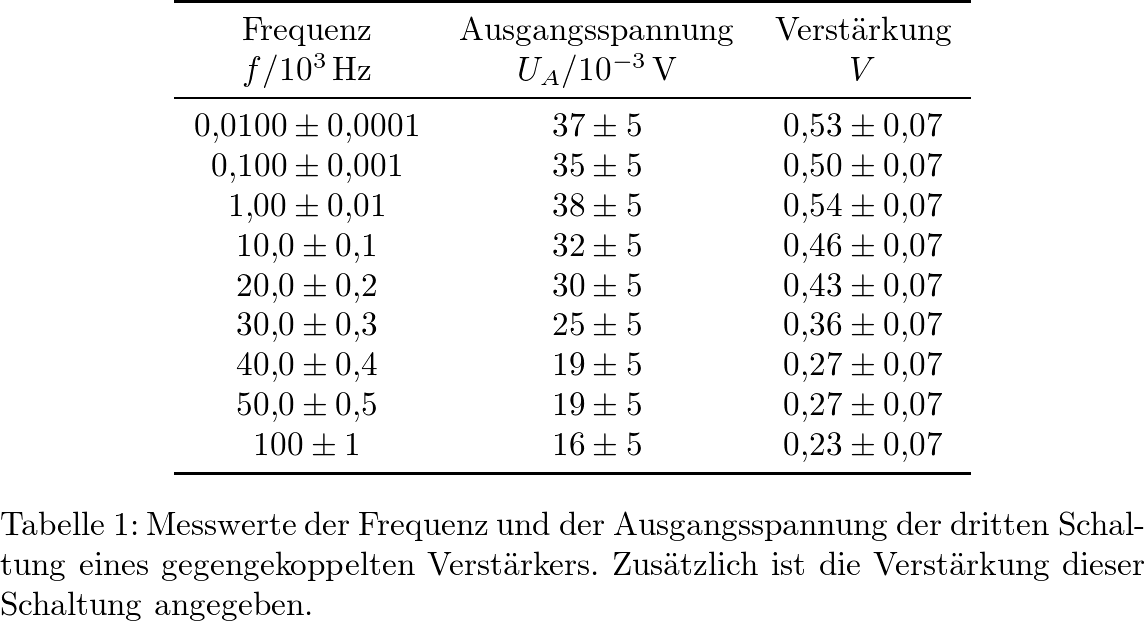

In [35]:
Tab = Table(siunitx=True,booktabs=True)
Tab.caption("""Messwerte der Frequenz und der Ausgangsspannung der dritten Schaltung eines gegengekoppelten Verstärkers.
            Zusätzlich ist die Verstärkung dieser Schaltung angegeben.""")
Tab.label("gegengekoppelter_verstaerker_3")
Tab.addColumn(degenerative_amplifier_3["f"],title="Frequenz",symbol="f",unit="\\kilo\\hertz")
Tab.addColumn(degenerative_amplifier_3["UA"],title="Ausgangsspannung",symbol="U_A",unit="\\milli\\volt")
Tab.addColumn(degenerative_amplifier_3["V"],title="Verstärkung",symbol="V")
Image(Tab.show(ipynb=True,quiet=False),width=800)

Tab.save(path_table+"Gegengekoppelter_Verstaerker_3.tex")

## Messreihe 4

In [36]:
degenerative_amplifier_4 = pd.read_csv(path_data + "Frequenzgang_Gegengekoppelter_Verstaerker_4.csv",
                                       skiprows=1, names=("f","U1","UA"))

degenerative_amplifier_4["f"] = unp.uarray(degenerative_amplifier_4["f"],
                                           degenerative_amplifier_4["f"]*degenerative_amplifier_err["f"][0])
degenerative_amplifier_4["U1"] = unp.uarray(degenerative_amplifier_4["U1"],
                                           degenerative_amplifier_err["U1"][0])
degenerative_amplifier_4["UA"] = unp.uarray(degenerative_amplifier_4["UA"],
                                           degenerative_amplifier_err["UA"][0])

degenerative_amplifier_4["V"] = degenerative_amplifier_4["UA"]/degenerative_amplifier_4["U1"]
degenerative_amplifier_4["logf"] = unp.log10(degenerative_amplifier_4["f"])
degenerative_amplifier_4["logV"] = unp.log10(degenerative_amplifier_4["V"])

In [37]:
degenerative_amplifier_4

,f,U1,UA,V,logf,logV
0,0.1000+/-0.0010,70.0+/-1.0,220.0+/-5.0,3.14+/-0.08,-1.000+/-0.004,0.497+/-0.012
1,1.000+/-0.010,70.0+/-1.0,230.0+/-5.0,3.29+/-0.09,0.000+/-0.004,0.517+/-0.011
2,5.00+/-0.05,70.0+/-1.0,160.0+/-5.0,2.29+/-0.08,0.699+/-0.004,0.359+/-0.015
3,10.00+/-0.10,70.0+/-1.0,100.0+/-5.0,1.43+/-0.07,1.000+/-0.004,0.155+/-0.023
4,20.00+/-0.20,70.0+/-1.0,60.0+/-5.0,0.86+/-0.07,1.301+/-0.004,-0.07+/-0.04
5,30.00+/-0.30,70.0+/-1.0,45.0+/-5.0,0.64+/-0.07,1.477+/-0.004,-0.19+/-0.05
6,50.0+/-0.5,70.0+/-1.0,35.0+/-5.0,0.50+/-0.07,1.699+/-0.004,-0.30+/-0.06
7,100.0+/-1.0,70.0+/-1.0,25.0+/-5.0,0.36+/-0.07,2.000+/-0.004,-0.45+/-0.09


In [38]:
popt, pcov = sp.optimize.curve_fit(linear_func, 
                                   noms(degenerative_amplifier_4["f"][2:]),
                                   noms(degenerative_amplifier_4["V"][2:]),
                                   sigma=stds(degenerative_amplifier_4["V"][2:]))
param_a, param_b = fit_errors(popt,pcov)

print_errors([param_a,param_b],description=("Steigung a","y-Achsenabschnitt b"))

x = np.linspace(min(noms(degenerative_amplifier_4["f"])), max(noms(degenerative_amplifier_4["f"])), 1000)
y = linear_func(x,noms(param_a), noms(param_b))

param_a_4,param_b_4 = param_a,param_b

Steigung a           -0.6773904095208729 +/- 0.019982447206770816
y-Achsenabschnitt b  0.8307837558466196 +/- 0.01941271719967101


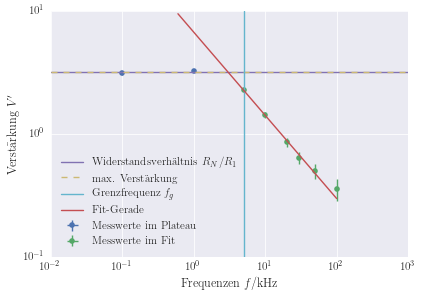

In [39]:
fig,ax = plt.subplots()
ax.set_xlabel(axis_label("Frequenzen", "f", "kHz"))
ax.set_ylabel(axis_label("Verstärkung", "V^{\prime}"))

ax.set_xscale("log")
ax.set_yscale("log")

plateau = np.mean(noms(degenerative_amplifier_4["V"][:2]))
plateau_sq2 = plateau/np.sqrt(2) 
frequency_limit  = (plateau_sq2/10**param_b)**(1/param_a) #sp.optimize.fsolve(lambda x:x**noms(param_a) * 10**noms(param_b) - plateau_sq2,x0=1)


errorbar(degenerative_amplifier_4["f"][:2],degenerative_amplifier_4["V"][:2],
        marker="o", linestyle="", ax=ax, label="Messwerte im Plateau")
errorbar(degenerative_amplifier_4["f"][2:],degenerative_amplifier_4["V"][2:],
        marker="o", linestyle="", ax=ax, label="Messwerte im Fit")

ax.axhline(noms(degenerative_amplifier_resistors["RN"][3]/degenerative_amplifier_resistors["R1"][3]), 
           label="Widerstandsverhältnis $R_N/R_1$",color=colors[3])

ax.axhline(plateau, label="max. Verstärkung",linestyle="dashed",color=colors[4])
ax.axvline(frequency_limit.n,color=colors[5], label="Grenzfrequenz $f_g$")


ylim = ax.get_ylim()
ylim_mask = (y>ylim[0])&(y<ylim[1])

ax.plot(x[ylim_mask],y[ylim_mask],label="Fit-Gerade")
ax.legend(loc="lower left")
fig.savefig(path_graphics+"Gegengekoppelter_Verstaerker_4.pdf")


In [40]:
f_4 = frequency_limit
Vf_4 = frequency_limit * plateau
print("Grenzfrequenz", frequency_limit, "kHz")
print("Verstärkung-Bandbreite-Produkt",frequency_limit * plateau)
plateau_4 = plateau
resistor_ratio_4 = noms(degenerative_amplifier_resistors["RN"]/degenerative_amplifier_resistors["R1"])[3]
relative_difference_4 = abs(resistor_ratio_4- plateau_4)/resistor_ratio_4
idel_amplification_4 = noms(degenerative_amplifier_resistors["RN"] * plateau /(degenerative_amplifier_resistors["RN"]
                                                              - (degenerative_amplifier_resistors["R1"] * plateau)))[3]
print("Widerstandsverhältnis", resistor_ratio_4)
print("Plateau-Höhe", plateau_4)
print("relative Abweichung", relative_difference_4)
print("Leerlaufverstärkung",idel_amplification_4)


Grenzfrequenz 5.0+/-0.4 kHz
Verstärkung-Bandbreite-Produkt 16.1+/-1.3
Widerstandsverhältnis 3.2
Plateau-Höhe 3.21428571429
relative Abweichung 0.00446428571429
Leerlaufverstärkung -720.0


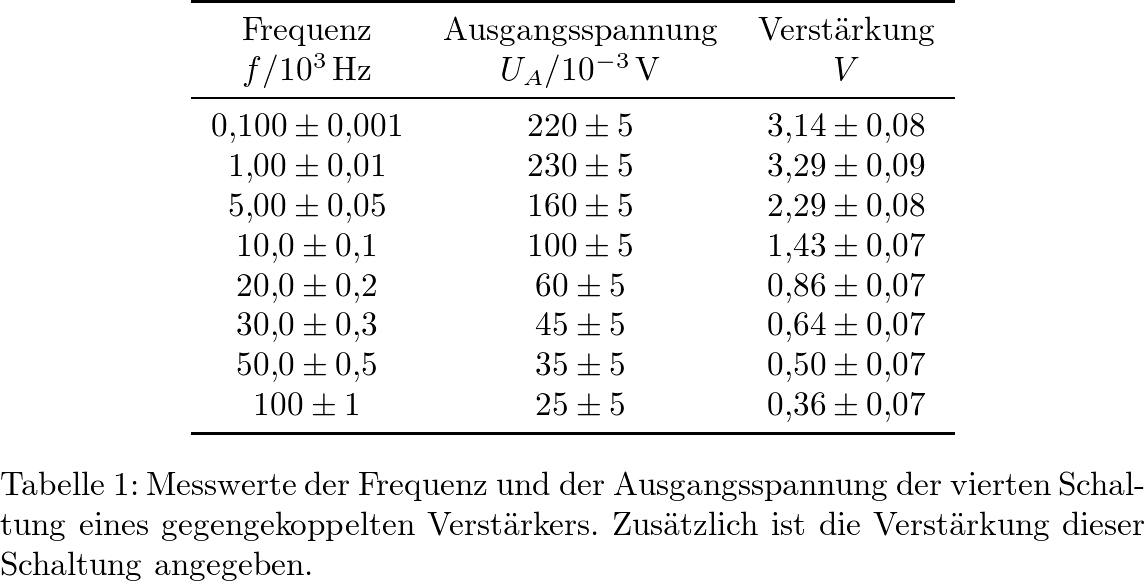

In [41]:
Tab = Table(siunitx=True,booktabs=True)
Tab.caption("""Messwerte der Frequenz und der Ausgangsspannung der vierten Schaltung eines gegengekoppelten Verstärkers.
            Zusätzlich ist die Verstärkung dieser Schaltung angegeben.""")
Tab.label("gegengekoppelter_verstaerker_4")
Tab.addColumn(degenerative_amplifier_4["f"],title="Frequenz",symbol="f",unit="\\kilo\\hertz")
Tab.addColumn(degenerative_amplifier_4["UA"],title="Ausgangsspannung",symbol="U_A",unit="\\milli\\volt")
Tab.addColumn(degenerative_amplifier_4["V"],title="Verstärkung",symbol="V")
Image(Tab.show(ipynb=True,quiet=False),width=800)

Tab.save(path_table+"Gegengekoppelter_Verstaerker_4.tex")

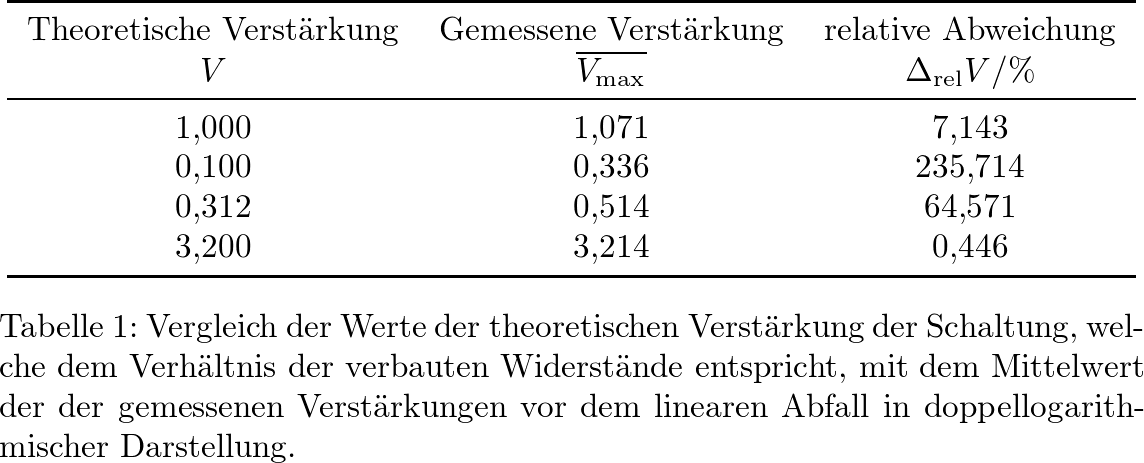

In [42]:
Tab = Table(siunitx=True,booktabs=True)
Tab.caption(""" Vergleich der Werte der theoretischen Verstärkung der Schaltung, welche dem Verhältnis der verbauten 
Widerstände entspricht, mit dem Mittelwert der der gemessenen Verstärkungen vor dem linearen Abfall in doppellogarithmischer Darstellung.""")
Tab.label("gegengekoppelter_verstaerker_max_verstaerkung")
Tab.addColumn([resistor_ratio_1,resistor_ratio_2,resistor_ratio_3,resistor_ratio_4],title="Theoretische Verstärkung",symbol="V")
Tab.addColumn([plateau_1,plateau_2,plateau_3,plateau_4],title="Gemessene Verstärkung",symbol="\\overline{V_{\\mathrm{max}}}")
Tab.addColumn([100*relative_difference_1,100*relative_difference_2,100*relative_difference_3,100*relative_difference_4 ],title="relative Abweichung",symbol="\\Delta_{\\mathrm{rel}} V",unit="\\percent")
Image(Tab.show(ipynb=True,quiet=False),width=800)

Tab.save(path_table+"Gegengekoppelter_Verstaerker_Verstaerkung.tex")

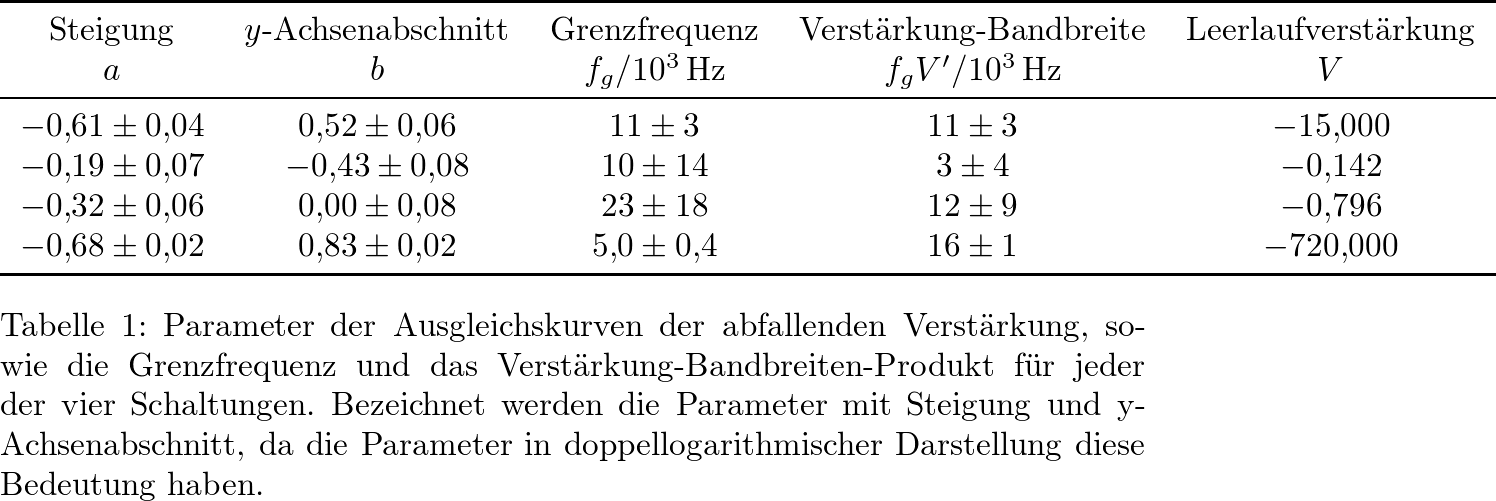

In [43]:
Tab = Table(siunitx=True,booktabs=True)
Tab.caption(""" Parameter der Ausgleichskurven der abfallenden Verstärkung, sowie die Grenzfrequenz und das 
Verstärkung-Bandbreiten-Produkt für jeder der vier Schaltungen. Bezeichnet werden die Parameter mit Steigung und 
y-Achsenabschnitt, da die Parameter in doppellogarithmischer Darstellung diese Bedeutung haben.""")
Tab.label("gegengekoppleter_verstaerker_parameter")
Tab.addColumn([param_a_1,param_a_2,param_a_3,param_a_4],title="Steigung",symbol="a")
Tab.addColumn([param_b_1,param_b_2,param_b_3,param_b_4],title="$y$-Achsenabschnitt",symbol="b")
Tab.addColumn([f_1,f_2,f_3,f_4],title="Grenzfrequenz",symbol="f_g",unit="\\kilo\\hertz")
Tab.addColumn([Vf_1,Vf_2,Vf_3,Vf_4],title="Verstärkung-Bandbreite",symbol="f_gV^{\prime}",unit="\\kilo\\hertz")
Tab.addColumn([idel_amplification_1,idel_amplification_2,idel_amplification_3,idel_amplification_4],
              title="Leerlaufverstärkung",symbol="V")

Image(Tab.show(ipynb=True,quiet=False),width=800)

Tab.save(path_table+"Gegengekoppelter_Verstaerker_Parameter.tex")

In [44]:
degenerative_amplifier_phase = pd.read_csv(path_data + "Phase_Gegengekoppelter_Verstaerker_4.csv",
                                       skiprows=1, names=("f","Phase","UA"))

In [45]:
degenerative_amplifier_phase

,f,Phase,UA
0,0.1,175,225
1,0.2,170,225
2,0.3,168,225
3,0.4,168,225
4,0.5,165,225
5,1.0,162,223
6,2.0,150,205
7,3.0,140,185
8,4.0,130,170
9,5.0,125,155


In [46]:
degenerative_amplifier_phase["f"] = unp.uarray(degenerative_amplifier_phase["f"],
                                               degenerative_amplifier_phase["f"]*degenerative_amplifier_err["f"][0])
degenerative_amplifier_phase["Phase"] = unp.uarray(degenerative_amplifier_phase["Phase"],
                                                   degenerative_amplifier_err["Phase"][0])
degenerative_amplifier_phase["UA"] = unp.uarray(degenerative_amplifier_phase["UA"],
                                                degenerative_amplifier_err["UA"][0])

In [47]:
degenerative_amplifier_phase

,f,Phase,UA
0,0.1000+/-0.0010,175.0+/-5.0,225.0+/-5.0
1,0.2000+/-0.0020,170.0+/-5.0,225.0+/-5.0
2,0.3000+/-0.0030,168.0+/-5.0,225.0+/-5.0
3,0.400+/-0.004,168.0+/-5.0,225.0+/-5.0
4,0.500+/-0.005,165.0+/-5.0,225.0+/-5.0
5,1.000+/-0.010,162.0+/-5.0,223.0+/-5.0
6,2.000+/-0.020,150.0+/-5.0,205.0+/-5.0
7,3.000+/-0.030,140.0+/-5.0,185.0+/-5.0
8,4.00+/-0.04,130.0+/-5.0,170.0+/-5.0
9,5.00+/-0.05,125.0+/-5.0,155.0+/-5.0


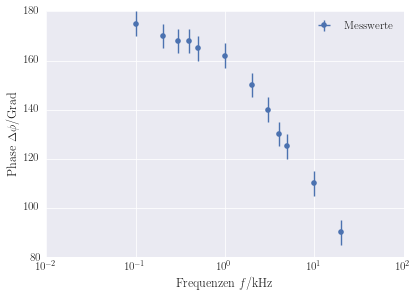

In [48]:
fig,ax = plt.subplots()
ax.set_xlabel(axis_label("Frequenzen", "f", "kHz"))
ax.set_ylabel(axis_label("Phase", "\Delta\phi","Grad"))
ax.set_xscale("log")

errorbar(degenerative_amplifier_phase["f"][:],degenerative_amplifier_phase["Phase"][:],
        marker="o", linestyle="", ax=ax, label="Messwerte")
#errorbar(degenerative_amplifier_4["f"][2:],degenerative_amplifier_4["V"][2:],
#        marker="o", linestyle="", ax=ax, label="Messwerte $f> f_g$")

#ax.axhline(noms(degenerative_amplifier_resistors["RN"][3]/degenerative_amplifier_resistors["R1"][3]), 
#          label="Widerstandsverhältnis $R_N/R_1$",color=colors[3])

#ylim = ax.get_ylim()
#ylim_mask = (y>ylim[0])&(y<ylim[1])

#ax.plot(x[ylim_mask],y[ylim_mask],label="Fit-Gerade")
ax.legend(loc="upper right")
fig.savefig(path_graphics+"Gegengekoppelter_Verstaerker_Phase.pdf")


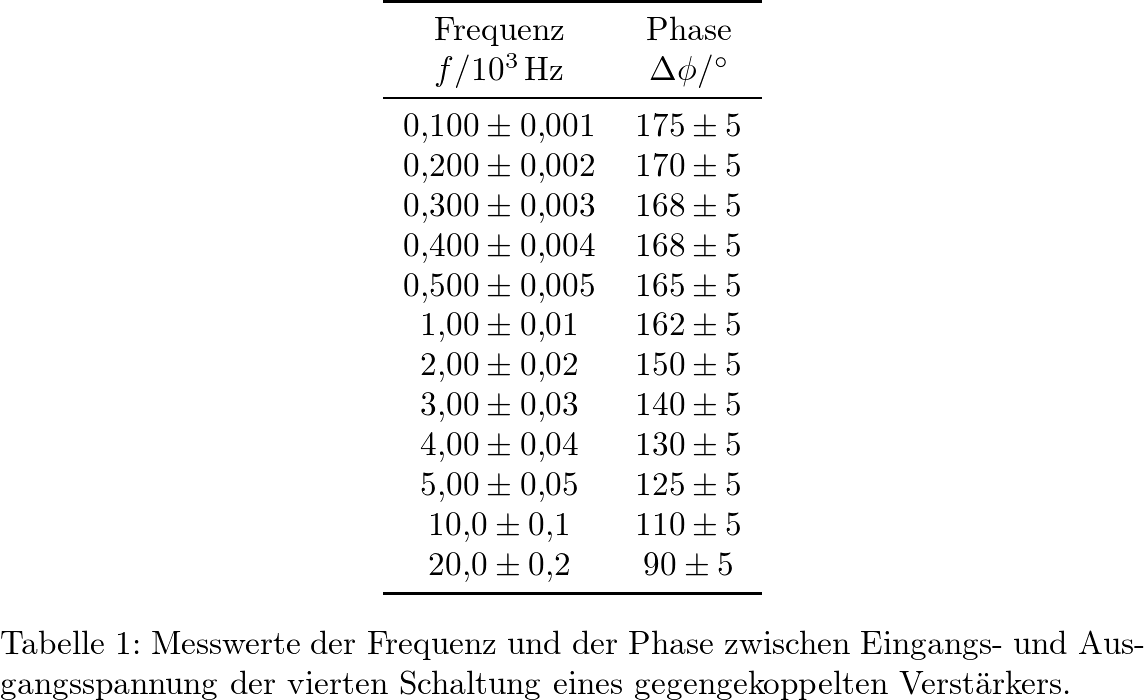

In [49]:
Tab = Table(siunitx=True,booktabs=True)
Tab.caption("""Messwerte der Frequenz und der Phase zwischen Eingangs- und Ausgangsspannung der vierten Schaltung 
eines gegengekoppelten Verstärkers.""")
Tab.label("gegengekoppelter_verstaerker_phase")
Tab.addColumn(degenerative_amplifier_phase["f"],title="Frequenz",symbol="f",unit="\\kilo\\hertz")
Tab.addColumn(degenerative_amplifier_phase["Phase"],title="Phase",symbol="\\Delta \\phi",unit="\\degree")
Image(Tab.show(ipynb=True,quiet=False),width=800)

Tab.save(path_table+"Gegengekoppelter_Verstaerker_Phase.tex")

## Messdaten zum Integrator d)

In [50]:
integrator = pd.read_csv(path_data+"Frequenzgang_Integrator.csv", skiprows=1, names=("f","UA"))

integrator_err = pd.read_csv(path_data+"Fehler_Integrator.csv", skiprows=1, names=("f","UA","R"))

In [51]:
integrator["f"] = unp.uarray(integrator["f"], integrator["f"]*integrator_err["f"][0])
integrator["UA"] = unp.uarray(integrator["UA"], integrator_err["UA"][0])

integrator["logf"] = unp.log10(integrator["f"])
integrator["logUA"] = unp.log10(integrator["UA"])

In [52]:
integrator

,f,UA,logf,logUA
0,100.0+/-1.0,670.0+/-10.0,2.000+/-0.004,2.826+/-0.006
1,200.0+/-2.0,350.0+/-10.0,2.301+/-0.004,2.544+/-0.012
2,300.0+/-3.0,250.0+/-10.0,2.477+/-0.004,2.398+/-0.017
3,400.0+/-4.0,180.0+/-10.0,2.602+/-0.004,2.255+/-0.024
4,500.0+/-5.0,160.0+/-10.0,2.699+/-0.004,2.204+/-0.027
5,600.0+/-6.0,140.0+/-10.0,2.778+/-0.004,2.146+/-0.031
6,700.0+/-7.0,120.0+/-10.0,2.845+/-0.004,2.08+/-0.04
7,800.0+/-8.0,100.0+/-10.0,2.903+/-0.004,2.00+/-0.04
8,900.0+/-9.0,90.0+/-10.0,2.954+/-0.004,1.95+/-0.05
9,1000.0+/-10.0,80.0+/-10.0,3.000+/-0.004,1.90+/-0.05


In [53]:
popt, pcov = sp.optimize.curve_fit(linear_func, 
                                   noms(integrator["f"][:]),
                                   noms(integrator["UA"][:]),
                                   sigma=stds(integrator["UA"][:]))
param_a, param_b = fit_errors(popt,pcov)

print_errors([param_a,param_b],description=("Steigung a","y-Achsenabschnitt b"))

x = np.linspace(min(noms(integrator["f"])), max(noms(integrator["f"])), 1000)
y = linear_func(x,noms(param_a), noms(param_b))



Steigung a           -0.906547929601287 +/- 0.01060464728719671
y-Achsenabschnitt b  4.637839462233714 +/- 0.023588320273295587


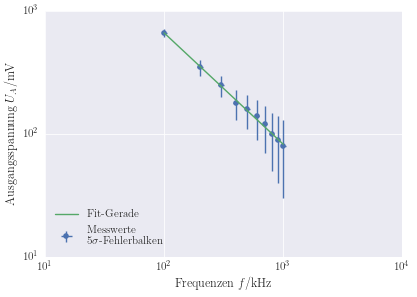

In [54]:
fig,ax = plt.subplots()
ax.set_xlabel(axis_label("Frequenzen", "f", "kHz"))
ax.set_ylabel(axis_label("Ausgangsspannung", "U_{A}", "mV"))

ax.set_xscale("log")
ax.set_yscale("log")

errorbar(integrator["f"][:],integrator["UA"][:],factor=5,
        marker="o", linestyle="", ax=ax, label="Messwerte\n $5\sigma$-Fehlerbalken")

#ax.axhline(noms(unp.log10(degenerative_amplifier_resistors["RN"][3]/degenerative_amplifier_resistors["R1"][3])), 
#          label="Widerstandsverhältnis $R_N/R_1$",color=colors[3])

ylim = ax.get_ylim()
ylim_mask = (y>ylim[0])&(y<ylim[1])

ax.plot(x[ylim_mask],y[ylim_mask],label="Fit-Gerade")
ax.legend(loc="lower left")
fig.savefig(path_graphics+"Integrator_Frequenz.pdf")


In [55]:
integrator_oscilloscope_sin = pd.read_csv(path_data+"Oszilloskop_Integrator_400Hz/Eingang_Sinus.csv",
                                              skiprows=2, names=("t","UA","UE"))
integrator_oscilloscope_tri = pd.read_csv(path_data+"Oszilloskop_Integrator_400Hz/Eingang_Dreieck.csv",
                                              skiprows=2, names=("t","UA","UE"))
integrator_oscilloscope_rec = pd.read_csv(path_data+"Oszilloskop_Integrator_400Hz/Eingang_Rechteck.csv",
                                              skiprows=2, names=("t","UA","UE"))

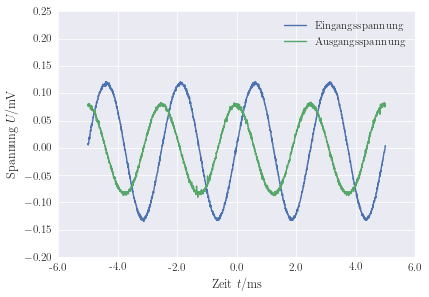

In [56]:
fig,ax = plt.subplots()
axis_scale(factor=1e3,axis="x")
ax.set_xlabel(axis_label("Zeit", "t", "ms"))
ax.set_ylabel(axis_label("Spannung", "U", "mV"))
ax.set_ylim(-0.2,0.25)
ax.plot(integrator_oscilloscope_sin["t"],integrator_oscilloscope_sin["UE"],label="Eingangsspannung")
ax.plot(integrator_oscilloscope_sin["t"],integrator_oscilloscope_sin["UA"],label="Ausgangsspannung")
ax.legend(loc="upper right")
fig.savefig(path_graphics+"Integrator_Oszilloskop_Sinus.pdf")


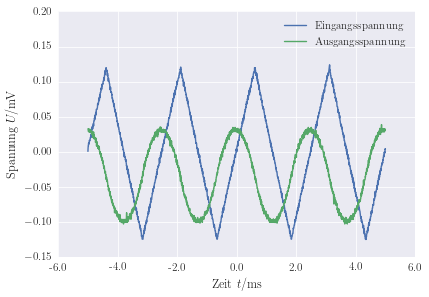

In [57]:
fig,ax = plt.subplots()
axis_scale(factor=1e3,axis="x")
ax.set_xlabel(axis_label("Zeit", "t", "ms"))
ax.set_ylabel(axis_label("Spannung", "U", "mV"))
ax.set_ylim(-0.15,0.2)
ax.plot(integrator_oscilloscope_tri["t"],integrator_oscilloscope_tri["UE"],label="Eingangsspannung")
ax.plot(integrator_oscilloscope_tri["t"],integrator_oscilloscope_tri["UA"],label="Ausgangsspannung")
ax.legend(loc="upper right")
fig.savefig(path_graphics+"Integrator_Oszilloskop_Dreieck.pdf")


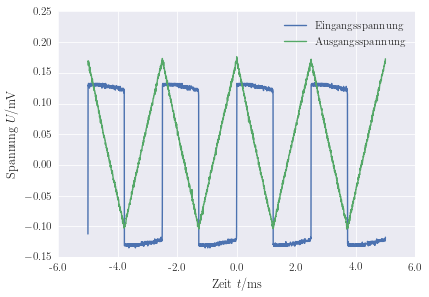

In [58]:
fig,ax = plt.subplots()
axis_scale(factor=1e3,axis="x")
ax.set_xlabel(axis_label("Zeit", "t", "ms"))
ax.set_ylabel(axis_label("Spannung", "U", "mV"))
ax.set_ylim(-0.15,0.25)
ax.plot(integrator_oscilloscope_rec["t"],integrator_oscilloscope_rec["UE"],label="Eingangsspannung")
ax.plot(integrator_oscilloscope_rec["t"],integrator_oscilloscope_rec["UA"],label="Ausgangsspannung")
ax.legend(loc="upper right")
fig.savefig(path_graphics+"Integrator_Oszilloskop_Rechteck.pdf")


In [59]:
differentiator = pd.read_csv(path_data+"Frequenzgang_Differentiator.csv", skiprows=1, names=("f","UA"))

differentiator_err = pd.read_csv(path_data+"Fehler_Differentiator.csv", skiprows=1, names=("f","UA","R"))

In [60]:
differentiator["f"] = unp.uarray(differentiator["f"], differentiator["f"]*differentiator_err["f"][0])
differentiator["UA"] = unp.uarray(differentiator["UA"], differentiator_err["UA"][0])

differentiator["logf"] = unp.log10(differentiator["f"])
differentiator["logUA"] = unp.log10(differentiator["UA"])

In [61]:
differentiator

,f,UA,logf,logUA
0,100.0+/-1.0,140.0+/-10.0,2.000+/-0.004,2.146+/-0.031
1,200.0+/-2.0,240.0+/-10.0,2.301+/-0.004,2.380+/-0.018
2,300.0+/-3.0,350.0+/-10.0,2.477+/-0.004,2.544+/-0.012
3,400.0+/-4.0,450.0+/-10.0,2.602+/-0.004,2.653+/-0.010
4,500.0+/-5.0,550.0+/-10.0,2.699+/-0.004,2.740+/-0.008
5,600.0+/-6.0,640.0+/-10.0,2.778+/-0.004,2.806+/-0.007
6,700.0+/-7.0,740.0+/-10.0,2.845+/-0.004,2.869+/-0.006
7,800.0+/-8.0,840.0+/-10.0,2.903+/-0.004,2.924+/-0.005
8,900.0+/-9.0,920.0+/-10.0,2.954+/-0.004,2.964+/-0.005
9,1000.0+/-10.0,1040.0+/-10.0,3.000+/-0.004,3.017+/-0.004


In [62]:
popt, pcov = sp.optimize.curve_fit(linear_func, 
                                   noms(differentiator["f"][:]),
                                   noms(differentiator["UA"][:]),
                                   sigma=stds(differentiator["UA"][:]))
param_a, param_b = fit_errors(popt,pcov)

print_errors([param_a,param_b],description=("Steigung a","y-Achsenabschnitt b"))

x = np.linspace(min(noms(differentiator["f"])), max(noms(differentiator["f"])), 1000)
y = linear_func(x,noms(param_a), noms(param_b))



Steigung a           0.8994746172449467 +/- 0.01152732378072151
y-Achsenabschnitt b  0.31231762902616494 +/- 0.0330777456740357


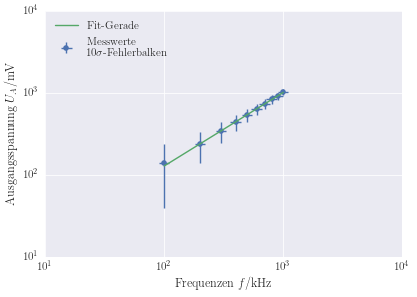

In [63]:
fig,ax = plt.subplots()
ax.set_xlabel(axis_label("Frequenzen", "f", "kHz"))
ax.set_ylabel(axis_label("Ausgangsspannung", "U_{A}", "mV"))

ax.set_xscale("log")
ax.set_yscale("log")

errorbar(differentiator["f"][:],differentiator["UA"][:],
        marker="o", linestyle="", ax=ax, label="Messwerte\n $10\sigma$-Fehlerbalken", factor=10)

#ax.axhline(noms(unp.log10(degenerative_amplifier_resistors["RN"][3]/degenerative_amplifier_resistors["R1"][3])), 
#          label="Widerstandsverhältnis $R_N/R_1$",color=colors[3])

ylim = ax.get_ylim()
ylim_mask = (y>ylim[0])&(y<ylim[1])

ax.plot(x[ylim_mask],y[ylim_mask],label="Fit-Gerade")
ax.legend(loc="upper left")
fig.savefig(path_graphics+"Differentiator_Frequenz.pdf")


In [64]:
differentiator_oscilloscope_sin = pd.read_csv(path_data+"Oszilloskop_Differentiator_400Hz/Eingang_Sinus.csv",
                                              skiprows=2, names=("t","UA","UE"))
differentiator_oscilloscope_tri = pd.read_csv(path_data+"Oszilloskop_Differentiator_400Hz/Eingang_Dreieck.csv",
                                              skiprows=2, names=("t","UA","UE"))
differentiator_oscilloscope_rec = pd.read_csv(path_data+"Oszilloskop_Differentiator_400Hz/Eingang_Rechteck.csv",
                                              skiprows=2, names=("t","UA","UE"))

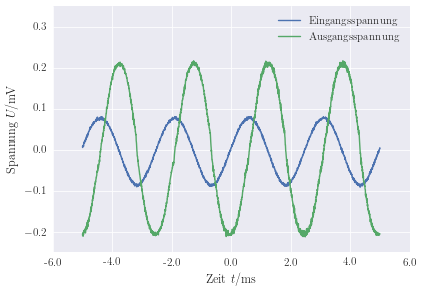

In [65]:
fig,ax = plt.subplots()
axis_scale(factor=1e3,axis="x")
ax.set_xlabel(axis_label("Zeit", "t", "ms"))
ax.set_ylabel(axis_label("Spannung", "U", "mV"))
ax.set_ylim(-0.25,0.35)
ax.plot(differentiator_oscilloscope_sin["t"],differentiator_oscilloscope_sin["UE"],label="Eingangsspannung")
ax.plot(differentiator_oscilloscope_sin["t"],differentiator_oscilloscope_sin["UA"],label="Ausgangsspannung")
ax.legend(loc="upper right")
fig.savefig(path_graphics+"Differentiator_Oszilloskop_Sinus.pdf")


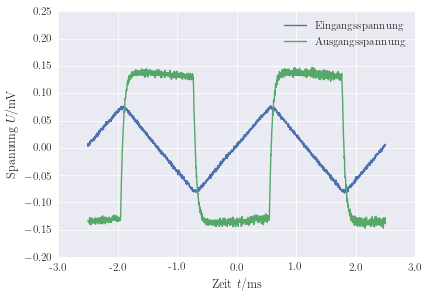

In [66]:
fig,ax = plt.subplots()
axis_scale(factor=1e3,axis="x")
ax.set_xlabel(axis_label("Zeit", "t", "ms"))
ax.set_ylabel(axis_label("Spannung", "U", "mV"))
ax.set_ylim(-0.2,0.25)
ax.plot(differentiator_oscilloscope_tri["t"],differentiator_oscilloscope_tri["UE"],label="Eingangsspannung")
ax.plot(differentiator_oscilloscope_tri["t"],differentiator_oscilloscope_tri["UA"],label="Ausgangsspannung")
ax.legend(loc="upper right")
fig.savefig(path_graphics+"Differentiator_Oszilloskop_Dreieck.pdf")


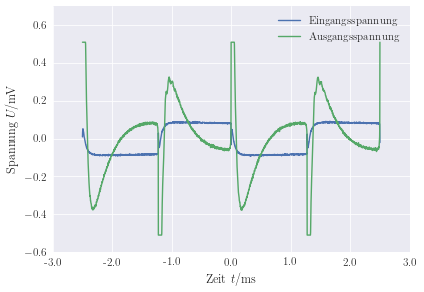

In [67]:
fig,ax = plt.subplots()
axis_scale(factor=1e3,axis="x")
ax.set_xlabel(axis_label("Zeit", "t", "ms"))
ax.set_ylabel(axis_label("Spannung", "U", "mV"))
ax.set_ylim(-0.6,0.7)
ax.plot(differentiator_oscilloscope_rec["t"],differentiator_oscilloscope_rec["UE"],label="Eingangsspannung")
ax.plot(differentiator_oscilloscope_rec["t"],differentiator_oscilloscope_rec["UA"],label="Ausgangsspannung")
ax.legend(loc="upper right")
fig.savefig(path_graphics+"Differentiator_Oszilloskop_Rechteck.pdf")


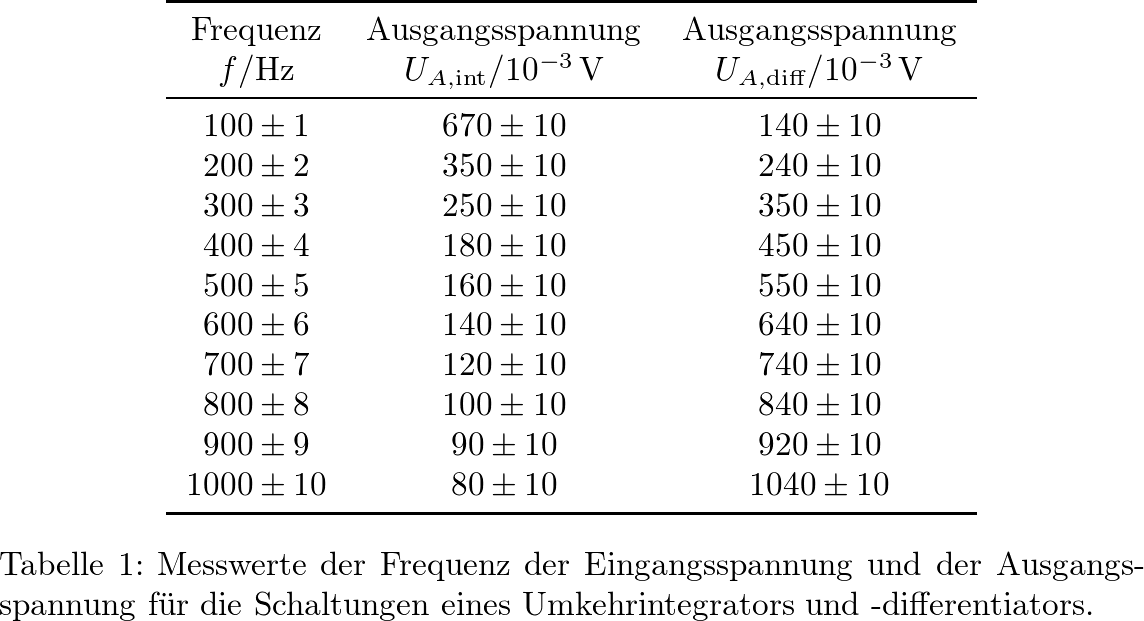

In [68]:
Tab = Table(siunitx=True,booktabs=True)
Tab.caption(""" Messwerte der Frequenz der Eingangsspannung und der Ausgangsspannung für die Schaltungen eines Umkehrintegrators und -differentiators.""")
Tab.label("integrator_differentiator")
Tab.addColumn(integrator["f"],title="Frequenz",symbol="f",unit="\\hertz")
Tab.addColumn(integrator["UA"],title="Ausgangsspannung",symbol="U_{A,\\mathrm{int}}",unit="\\milli\\volt")
Tab.addColumn(differentiator["UA"],title="Ausgangsspannung",symbol="U_{A,\\mathrm{diff}}",unit="\\milli\\volt")
Image(Tab.show(ipynb=True,quiet=False),width=800)

Tab.save(path_table+"Integrator_Differntiator.tex")

## Schmitt-Trigger

In [69]:
trigger = pd.read_csv(path_data+"Daten_Schmitt_Trigger.csv", skiprows=1, names=("Rp","R1","UK","UA"))

trigger_err = pd.read_csv(path_data+"Fehler_Schmitt_Trigger.csv", skiprows=1, names=("R","UK","UA"))

In [70]:
trigger["Rp"] = unp.uarray(trigger["Rp"],trigger["Rp"]*trigger_err["R"][0])
trigger["R1"] = unp.uarray(trigger["R1"],trigger["R1"]*trigger_err["R"][0])
trigger["UK"] = unp.uarray(trigger["UK"],trigger_err["UK"][0])
trigger["UA"] = unp.uarray(trigger["UA"],trigger_err["UA"][0])

In [71]:
trigger

,Rp,R1,UK,UA
0,(1.000+/-0.010)e+04,470.0+/-4.7,340.0+/-10.0,28.10+/-0.10


In [72]:

print("Gemessene Kippspannung:",trigger["UK"][0]*1e-3, "V")
save_results(trigger["UK"][0]*1e-3 ,"V",file="kippspannung_gemessen.txt")


print("Theoretische Kippspannung:",(trigger["UA"][0]/2* trigger["R1"]/trigger["Rp"])[0], "V")
save_results((unc.ufloat(10,0.5) * trigger["R1"]/trigger["Rp"])[0] ,"V",file="kippspannung_theoretisch.txt")

Gemessene Kippspannung: 0.340+/-0.010 V
Theoretische Kippspannung: 0.660+/-0.010 V


In [73]:
abs((trigger["UK"][0]*1e-3) - (trigger["UA"][0]/2* trigger["R1"]/trigger["Rp"])[0])/(unc.ufloat(10,0.5)* trigger["R1"]/trigger["Rp"])[0]

0.681595744680851+/-0.04175868972708496

In [74]:
for idx,unit in zip(trigger.columns,["\\ohm","\\ohm","\\milli\\volt","\\volt"]):
    save_results(trigger[idx][0],unit,file="schmitt_trigger_{}.txt".format(idx))

In [75]:
15*trigger["R1"][0]/trigger["Rp"][0]

0.705+/-0.009970205614730322

## Dreieck/Rechteck - Generator

In [76]:
function_generator = pd.read_csv(path_data+"Daten_Dreiecksgenerator.csv", skiprows=1, names=("R","R1","Rp","C","R0","R0'","URec","UTri","fRec","fTri"))
# R/Ohm, R1/Ohm, Rp/Ohm, C/F, R0/Ohm, R0'/Ohm, URecpp/V, Utripp/V, fRec/Hz, fTri/Hz
function_generator_err = pd.read_csv(path_data+"Fehler_Dreiecksgenerator.csv", skiprows=1, names=("R","Upp","f"))
#Impedanzen/%,Upp/mV, f/Hz

In [77]:
function_generator["R"] = unp.uarray(function_generator["R"],function_generator["R"]*function_generator_err["R"][0])
function_generator["R1"] = unp.uarray(function_generator["R1"],function_generator["R1"]*function_generator_err["R"][0])
function_generator["Rp"] = unp.uarray(function_generator["Rp"],function_generator["Rp"]*function_generator_err["R"][0])
function_generator["R0"] = unp.uarray(function_generator["R0"],function_generator["R0"]*function_generator_err["R"][0])
function_generator["R0'"] = unp.uarray(function_generator["R0'"],function_generator["R0'"]*function_generator_err["R"][0])
function_generator["C"] = unp.uarray(function_generator["C"],function_generator["C"]*function_generator_err["R"][0])
function_generator["URec"] = unp.uarray(function_generator["URec"],function_generator_err["Upp"][0])
function_generator["UTri"] = unp.uarray(function_generator["UTri"],function_generator_err["Upp"][0])
function_generator["fRec"] = unp.uarray(function_generator["fRec"],function_generator_err["f"][0])
function_generator["fTri"] = unp.uarray(function_generator["fTri"],function_generator_err["f"][0])


In [78]:
function_generator

,R,R1,Rp,C,R0,R0',URec,UTri,fRec,fTri
0,560.0+/-5.6,1000.0+/-10.0,(1.000+/-0.010)e+05,(1.000+/-0.010)e-06,(3.200+/-0.032)e+04,(1.000+/-0.010)e+04,0.4700+/-0.0010,0.3300+/-0.0010,570.0+/-1.0,570.0+/-1.0


Theoretische Spannung:  
$U_{tri,pp} = U_{rec,pp} \cdot \frac{R_1}{R_P}$  
Theoretische Frequenz:   
$f = \frac{1}{4RC} \cdot \frac{R_p}{R_1}$

In [79]:
Ub = unc.ufloat(15.0,0.1)

In [80]:
freq = (0.25/((function_generator["R"] + function_generator["R0"]+function_generator["R0'"]) *
              function_generator["C"]) *(function_generator["Rp"])/(function_generator["R1"]))[0]
U_rec = (Ub - Ub/(function_generator["R"] + function_generator["R0"]+function_generator["R0'"]) * (function_generator["R0"]+function_generator["R0'"]) )[0]
U_tri = (Ub*(function_generator["R1"])/(function_generator["Rp"]))[0]
print("Theoretische Spannnug U_rec:", U_rec, "V")
print("Theoretische Spannnug U_tri:",U_tri, "V")
print("Theoretische Frequenz:", freq, "Hz")

Theoretische Spannnug U_rec: 0.1974+/-0.0028 V
Theoretische Spannnug U_tri: 0.1500+/-0.0023 V
Theoretische Frequenz: 587.4+/-11.2 Hz


In [81]:
for val,name,unit in zip([freq,U_rec,U_tri],["freq","urec","utri"],["\\volt","\\volt","\\hertz"]):
    save_results(val,unit,file="funktionsgenerator_{}.txt".format(name))

In [82]:
function_generator_oscilloscope = pd.read_csv(path_data+"Oszilloskop_Dreieckgenerator/Rechteck_Dreieck.csv",
                                              skiprows=2, names=("t","UA","UE"))

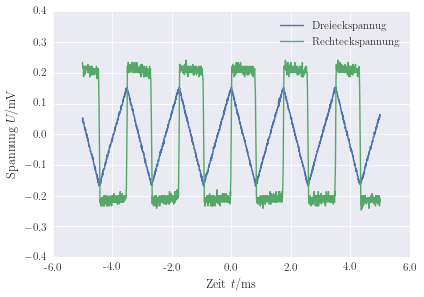

In [83]:
fig,ax = plt.subplots()
axis_scale(factor=1e3,axis="x")
ax.set_xlabel(axis_label("Zeit", "t", "ms"))
ax.set_ylabel(axis_label("Spannung", "U", "mV"))
ax.set_ylim(-0.4,0.4)
ax.plot(function_generator_oscilloscope["t"],function_generator_oscilloscope["UE"],label="Dreieckspannug")
ax.plot(function_generator_oscilloscope["t"],function_generator_oscilloscope["UA"],label="Rechteckspannung")
ax.legend(loc="upper right")
fig.savefig(path_graphics+"Funktionsgenerator.pdf")


## Ampermeter

In [98]:
amperemeter = pd.read_csv(path_data+"Frequenzgang_Amperemeter.csv", skiprows=1, names=("f","Ug","Ue","Ua"))
# R/Ohm, R1/Ohm, Rp/Ohm, C/F, R0/Ohm, R0'/Ohm, URecpp/V, Utripp/V, fRec/Hz, fTri/Hz
amperemeter_err = pd.read_csv(path_data+"Fehler_Amperemeter.csv", skiprows=1, names=("f","Ug","Ue","Ua","R"))
#Impedanzen/%,Upp/mV, f/Hz

In [99]:
Rn = unc.ufloat(10000, 10000*amperemeter_err["R"].values) #Ohm
Rv = unc.ufloat(100, 100*amperemeter_err["R"].values) #Ohm

In [100]:
amperemeter["f"] = unp.uarray(amperemeter["f"],(amperemeter["f"]*amperemeter_err["f"].values))
amperemeter["Ug"] = unp.uarray(amperemeter["Ug"],(amperemeter_err["Ug"].values))
amperemeter["Ue"] = unp.uarray(amperemeter["Ue"],(amperemeter_err["Ue"].values))
amperemeter["Ua"] = unp.uarray(amperemeter["Ua"],(amperemeter_err["Ua"].values))

In [101]:
amperemeter.head(5)


,f,Ug,Ue,Ua
0,100.0+/-1.0,0.2090+/-0.0010,0.0230+/-0.0020,20.00+/-0.10
1,200.0+/-2.0,0.2070+/-0.0010,0.0230+/-0.0020,20.00+/-0.10
2,500.0+/-5.0,0.2070+/-0.0010,0.0300+/-0.0020,20.00+/-0.10
3,750.0+/-7.5,0.2070+/-0.0010,0.0350+/-0.0020,20.00+/-0.10
4,1000.0+/-10.0,0.2070+/-0.0010,0.0400+/-0.0020,20.00+/-0.10


In [109]:
#amperemeter["I"] = amperemeter["Ug"].values/Rv
amperemeter["re"] = amperemeter["Ue"].values * Rv/amperemeter["Ug"].values
amperemeter["Ua'"] = amperemeter["Ug"].values/Rv * Rn
amperemeter["rel_Ua_Ua'"] = 100*(abs(amperemeter["Ua"]-amperemeter["Ua'"])/amperemeter["Ua"]).values
amperemeter["V"] = amperemeter["Ua"]/amperemeter["Ue"].values 
amperemeter["V_theo"] = Rn/(amperemeter["Ue"].values * Rv/amperemeter["Ug"].values)

In [103]:
amperemeter.head(5)


,f,Ug,Ue,Ua,re,Ua',rel_Ua_Ua',V,V_theo
0,100.0+/-1.0,0.2090+/-0.0010,0.0230+/-0.0020,20.00+/-0.10,11.0+/-1.0,20.90+/-0.31,4.5+/-1.6,(9.1+/-0.8)e+02,(9.1+/-0.8)e+02
1,200.0+/-2.0,0.2070+/-0.0010,0.0230+/-0.0020,20.00+/-0.10,11.1+/-1.0,20.70+/-0.31,3.5+/-1.6,(9.0+/-0.8)e+02,(9.0+/-0.8)e+02
2,500.0+/-5.0,0.2070+/-0.0010,0.0300+/-0.0020,20.00+/-0.10,14.5+/-1.0,20.70+/-0.31,3.5+/-1.6,(6.9+/-0.5)e+02,(6.9+/-0.5)e+02
3,750.0+/-7.5,0.2070+/-0.0010,0.0350+/-0.0020,20.00+/-0.10,16.9+/-1.0,20.70+/-0.31,3.5+/-1.6,591.4+/-34.9,591.4+/-34.9
4,1000.0+/-10.0,0.2070+/-0.0010,0.0400+/-0.0020,20.00+/-0.10,19.3+/-1.0,20.70+/-0.31,3.5+/-1.6,517.5+/-27.0,517.5+/-27.0


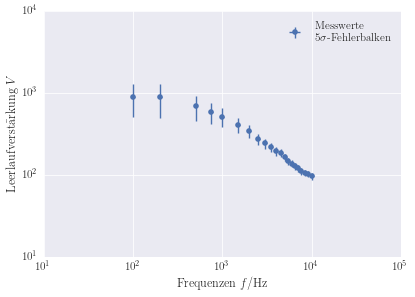

In [104]:
fig,ax = plt.subplots()
ax.set_xlabel(axis_label("Frequenzen", "f", "Hz"))
ax.set_ylabel(axis_label("Leerlaufverstärkung", "V"))

ax.set_xscale("log")
ax.set_yscale("log")

errorbar(amperemeter["f"][:],amperemeter["V"][:],factor=5,
        marker="o", linestyle="", ax=ax, label="Messwerte\n $5\sigma$-Fehlerbalken")

#ax.axhline(noms(unp.log10(degenerative_amplifier_resistors["RN"][3]/degenerative_amplifier_resistors["R1"][3])), 
#          label="Widerstandsverhältnis $R_N/R_1$",color=colors[3])

ax.legend(loc="upper right")
fig.savefig(path_graphics+"Amperemeter_Leerlaufverstaerkung.pdf")


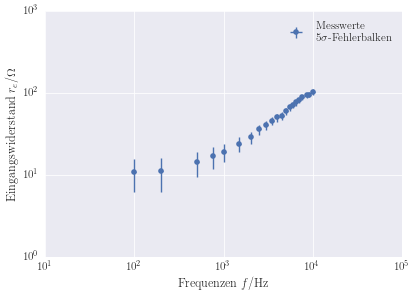

In [105]:
fig,ax = plt.subplots()
ax.set_xlabel(axis_label("Frequenzen", "f", "Hz"))
ax.set_ylabel(axis_label("Eingangswiderstand", "r_e", "\Omega"))

ax.set_xscale("log")
ax.set_yscale("log")

errorbar(amperemeter["f"][:],amperemeter["re"][:],factor=5,
        marker="o", linestyle="", ax=ax, label="Messwerte\n $5\sigma$-Fehlerbalken")

#ax.axhline(noms(unp.log10(degenerative_amplifier_resistors["RN"][3]/degenerative_amplifier_resistors["R1"][3])), 
#          label="Widerstandsverhältnis $R_N/R_1$",color=colors[3])

ax.legend(loc="upper right")
fig.savefig(path_graphics+"Amperemeter_Eingangswiderstand.pdf")


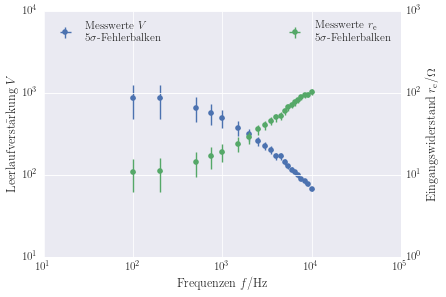

In [118]:
fig,ax = plt.subplots()
ax.set_xlabel(axis_label("Frequenzen", "f", "Hz"))
ax.set_ylabel(axis_label("Leerlaufverstärkung", "V"))
ax_ = ax.twinx()

ax_.set_ylabel(axis_label("Eingangswiderstand", "r_{\mathrm{e}}", "\Omega"))

ax.set_xscale("log")
ax.set_yscale("log")
ax_.set_yscale("log")

errorbar(amperemeter["f"][:],amperemeter["V"][:],factor=5,
        marker="o", linestyle="", ax=ax, label="Messwerte $V$ \n $5\sigma$-Fehlerbalken")
errorbar(amperemeter["f"][:],amperemeter["re"][:],factor=5,
        marker="o", linestyle="", ax=ax_,color=colors[1], label="Messwerte $r_{\mathrm{e}}$\n $5\sigma$-Fehlerbalken")


#ax.axhline(noms(unp.log10(degenerative_amplifier_resistors["RN"][3]/degenerative_amplifier_resistors["R1"][3])), 
#          label="Widerstandsverhältnis $R_N/R_1$",color=colors[3])

ax.legend(loc="upper left")
ax_.legend(loc="upper right")
fig.savefig(path_graphics+"Amperemeter_Leerlaufverstaerkung_Eingangswiderstand.pdf")


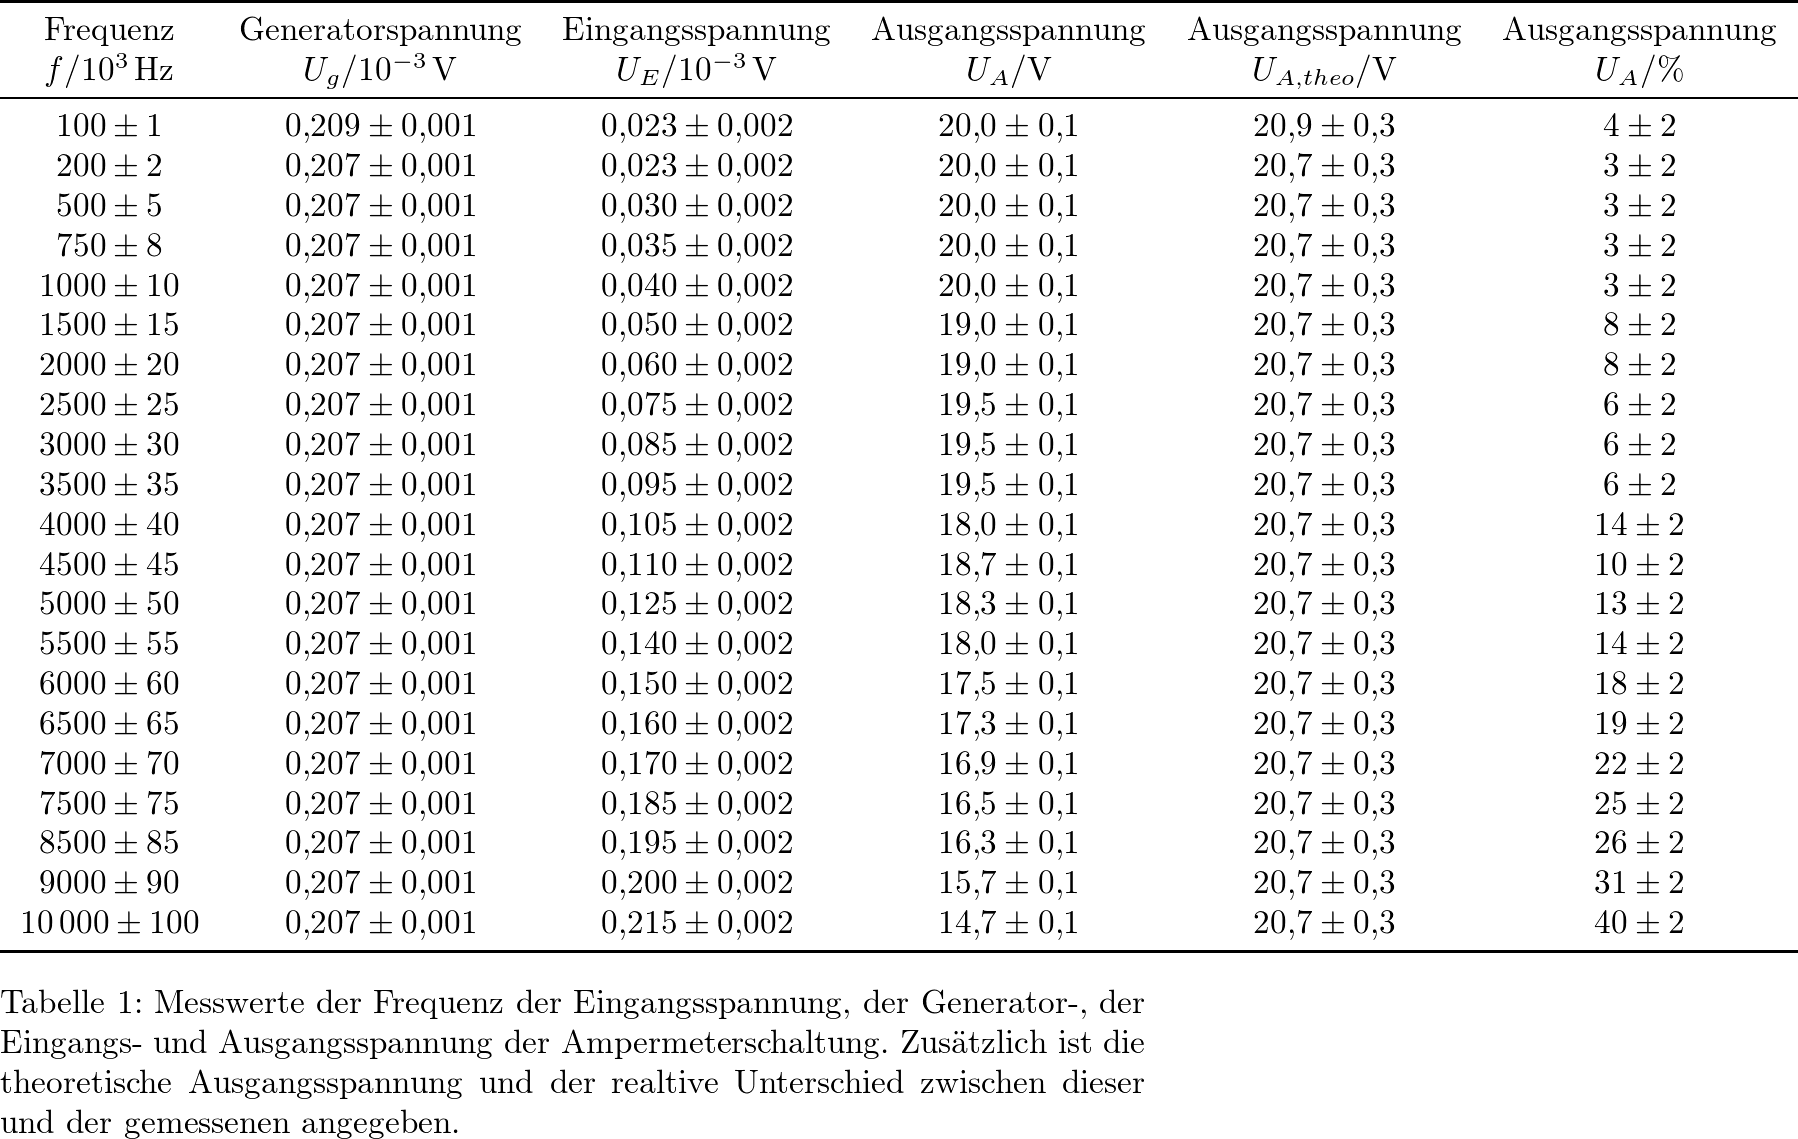

In [107]:
Tab = Table(siunitx=True,booktabs=True)
Tab.caption(""" Messwerte der Frequenz der Eingangsspannung, der Generator-, der Eingangs- und Ausgangsspannung
der Ampermeterschaltung. Zusätzlich ist die theoretische Ausgangsspannung und der realtive Unterschied zwischen dieser
und der gemessenen angegeben.""")
Tab.label("amperemeter_1")
Tab.addColumn(amperemeter["f"],title="Frequenz",symbol="f",unit="\\kilo\\hertz")
Tab.addColumn(amperemeter["Ug"],title="Generatorspannung",symbol="U_g",unit="\\milli\\volt")
Tab.addColumn(amperemeter["Ue"],title="Eingangsspannung",symbol="U_E",unit="\\milli\\volt")
Tab.addColumn(amperemeter["Ua"],title="Ausgangsspannung",symbol="U_A",unit="\\volt")
Tab.addColumn(amperemeter["Ua'"],title="Ausgangsspannung",symbol="U_{A,theo}",unit="\\volt")
Tab.addColumn(amperemeter["rel_Ua_Ua'"],title="Ausgangsspannung",symbol="U_A",unit="\\percent")
Image(Tab.show(ipynb=True,quiet=False),width=800)

## Nicht wenns nicht sein muss!
#Tab.save(path_table+"Amperemeter_1.tex")

In [115]:
Tab = Table(siunitx=True,booktabs=True)
Tab.caption(""" Aus den gemessenen Spannungen der Amperemeterschaltung berechnete Werte des Stroms und des Eingangswiderstands
sowie die aus letzterem berechneten Werte der Leerlaufverstärkung.""")
Tab.label("amperemeter_2")
Tab.addColumn(amperemeter["f"],title="Frequenz",symbol="f",unit="\\kilo\\hertz")
#Tab.addColumn(amperemeter["I"],title="Strom",symbol="I",unit="\\ampere")
Tab.addColumn([unc.ufloat(int(r.n),int(np.ceil(r.s))) if r.s < 1 else unc.ufloat(int(r.n),int(r.s)) for r in amperemeter["re"]],title="Eingangswiderstad",symbol="r_e",unit="\\ohm")
Tab.addColumn(amperemeter["V"],title="Leerlaufverstärkung",symbol="V")
Tab.addColumn(amperemeter["V_theo"],title="theoretische Leerlaufverstärkung",symbol="V_{\mathrm{theo}}")
#Image(Tab.show(ipynb=True,quiet=False),width=800)

Tab.save(path_table+"Amperemeter_2.tex")

In [95]:
a = unc.ufloat(1,2)

In [96]:
a.standard_deviation

AttributeError: 'Variable' object has no attribute 'standard_deviation'

In [ ]:
a = unc.ufloat(1,0.5)
b = unc.ufloat(5,0.1)
c =  a * b

In [ ]:
c

In [ ]:
c.s**2

In [ ]:
c_ec = c.error_components()
print(c_ec)

In [ ]:
2.5**2 + 0.1**2

In [ ]:
a.n * b.s

In [ ]:
b.n * a.s 